<a href="https://colab.research.google.com/github/HannaKi/Sentiment-analysis-with-IMDB-data/blob/main/Sentiment_analysis_with_IMDB_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

from pprint import pprint
# from time import time
# import logging

## Load and inspect data

In [143]:
%%bash
wget -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
tar -xf aclImdb_v1.tar.gz

File ‘aclImdb_v1.tar.gz’ already there; not retrieving.



In [144]:
%%bash
cd aclImdb
cat README | head -1000

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [23]:
# %%bash

# cd aclImdb/test/neg
# for f in *txt; do cat $f >> /content/texts.txt; done # appends all the reviews to file_names.txt
# # for f in *txt; do echo $f ; cat $f >> /content/file_names.txt; done # prints names and appends all the reviews to file_names.txt


In [ ]:
# %%bash
# head -1 /content/texts.txt
# # <br /><br />

In [ ]:
%%bash
cd aclImdb/test/neg
for f in *txt; do echo $f>> /content/neg_file_names.txt; done # appends filenames to file

In [146]:
%%bash
cd aclImdb/test/pos
for f in *txt; do echo $f>> /content/pos_file_names.txt; done # appends filenames to file

In [176]:
def open_file_by_looping(path, file):
  f=open(file)
  filenames = f.readlines()
  reviews = []
  for filename in filenames:
    fname = path + filename
    fname =fname.rstrip()
    f = open(fname)
    review = f.readlines()
    # print(type(review))
    reviews.append(review) # or extend?
    f.close()
  f.close()
  flat_list = [item for sublist in reviews for item in sublist] # we have list of lists, it needs to be flattened
  return flat_list

neg_reviews = open_file_by_looping("aclImdb/test/neg/", "neg_file_names.txt")
print("Number of negative reviews:", len(neg_reviews))

pos_reviews = open_file_by_looping("aclImdb/test/pos/", "pos_file_names.txt")
print("Number of positive reviews:", len(pos_reviews))

reviews=neg_reviews+pos_reviews
len(reviews)

Number of negative reviews: 12500
Number of positive reviews: 12500


25000

Data quality affects the performance of all machine learning algorithms and neural networks. Poor data can not be improved even with a sophisticated algorithm. In this case our data is balanced (classes have equal 50 % share) and well behaving in many aspects.

This is seldom true in real life applications. In these cases data balance must be taken care of with for example stratification or giving different weigths to different classes. If data is grouped or datarecords are not independent, even more caution should be given to the training process since this might lead to test data "leaking" into training data and thus highly optimistic model performance measeures. 

For these reasons one should familiarize her with a new dataset before rushing into further steps of modeling. If it is discovered that the data is imbalanced, grouped etc. we can fix the issues uprising from the nature of the data before we feed it to the algorithm, or at least take it in account when analysing the results. 

In [ ]:
import random
# make labels for the reviews:
labels = ['neg']*len(neg_reviews) + ['pos']*len(pos_reviews)
print(len(labels))

# make shuffled indices and shuffle both of the lists with them
indices = list(range(len(labels)))
random.shuffle(indices)

labels = [labels[index] for index in indices]
reviews = [reviews[index] for index in indices]

for label, text in zip(labels[:5], reviews[:5]):
  print("label:", label, "\ntext:", text, "\n")

# for i in range(31):
#   print(labels[i])
#   pprint(reviews[i])

In [ ]:
# s = r"\s\tWord"
# prog = re.compile(s)
# prog

# re.sub(some_regex, some_replacement.replace('\\', '\\\\'), input_string)

In [ ]:
# import re
# pattern1=r"<br /><br />" # something fishy is going on with HTML tags. Get rid of them
# s = "\\'"
# print(s)
# # pattern2=re.escape(r"\'")
# # print("p2:", pattern2)
# pattern3 = s
# print(pattern3)
# # print(pattern3.replace('\\', '\\\\'))
# print(chr(39))

# fixed = re.sub(pattern3, chr(39), reviews[8])
# fixed_n = re.sub(pattern1, " ", fixed)
# fixed_n

In [ ]:
import re
pattern1=r"<br /><br />" 
reviews = [re.sub(pattern1, " ", item) for item in reviews]

for i in range(31):
  print(i)
  pprint(reviews[i])

## UDPipe segmenting (is this needed?)

Let's try to tokenize and sentence split the IMDB data with UDPipe machine learned segmenter!
Documentation: https://ufal.mff.cuni.cz/udpipe/users-manual


In [179]:
!wget -nc https://github.com/TurkuNLP/intro-to-nlp/raw/master/Data/en.segmenter.udpipe

!pip3 install ufal.udpipe

import ufal.udpipe as udpipe

model = udpipe.Model.load("en.segmenter.udpipe")
pipeline = udpipe.Pipeline(model,"tokenize","none","none","horizontal") # horizontal: returns one sentence per line, with words separated by a single space


File ‘en.segmenter.udpipe’ already there; not retrieving.



In [106]:
segmented_document = pipeline.process(reviews[8])
print(segmented_document)

Being a long - time fan of Japanese film , I expected more than this .
I ca n't really be bothered to write to much , as this movie is just so poor .
The story might be the cutest romantic little something ever , pity I could n't stand the awful acting , the mess they called pacing , and the standard " quirky " Japanese story .
If you 've noticed how many Japanese movies use characters , plots and twists that seem too " different " , forcedly so , then steer clear of this movie .
Seriously , a 12 - year old could have told you how this movie was going to move along , and that 's not a good thing in my book .
Fans of " Beat " Takeshi : his part in this movie is not really more than a cameo , and unless you 're a rabid fan , you do n't need to suffer through this waste of film .
2/10



Preprocessing exhausts resources so let's cut down the input and take 100 st words from each review

In [114]:
cut = [item[:1000] for item in reviews]

# for i in range(10):
#   print(len(cut[i]))
#   print(cut[i])

In [115]:
segmented  = [pipeline.process(text) for text in cut]

In [ ]:
for i in range(30):
  print(segmented[i])

## train dev test split

In [219]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.33)

print(X_train[:5])
print(y_train[:5])
print(len(X_train), len(y_train))

["It is a shame that this series hasn't been remastered and produced on video by Warner or some other professional movie house. Copies of most episodes are available, but are usually of poor quality, being copies of copies of copies. As I understand it, 92 episodes were produced during its run, but only 15 are noted here. Some of the series writers, such as Richard Matheson, went on to become noted authors. Excellent series, well written, well staged and well produced. Michael Weldon, Udon Thani, Thailand", 'After the opening credits over a black sheet of paper with spots of white paint sprayed onto it, oh OK I\'ll be generous and call it a star field, we witness an alien spacecraft crashing into a meteorite and being forced to land on earth. A terrible looking model spacecraft lands on a terrible looking model field. Three nearby campers investigate. From the burning spacecraft a reptile like looking alien, the \'Nightbeast\' emerges, OK so I lied it\'s a guy in a dodgy rubber monster

## Tfidf

Since we are dealing with text data we need to transform it to format a basic SVM can handle. For that purpose I use sklearn TfidfVectorizer. 

In [220]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=50000)
fm_train = vectorizer.fit_transform(X_train)
fm_test = vectorizer.transform(X_test)

In [221]:
# input column number is limited by the vectorizer

print(f"We have {fm_train.shape[0]} rows and {fm_train.shape[1]} columns in the training data")
print(f"And {fm_test.shape[0]} rows and {fm_test.shape[1]} columns in the training data")


We have 16750 rows and 50000 columns in the training data
And 8250 rows and 50000 columns in the training data


In [222]:
# type of the input data is scipy.sparse.csr.csr_matrix
print(type(fm_train))

# What does it mean? It looks like this:
print(fm_train[0:2:])

# each row contains tfidf weights for a single review. 
# Columns are mostly empty because most words in the vovabulary do not appear in every sentence
# This is why sparse format is used
print(fm_train[0:2].todense())

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 42791)	0.1735820828721461
  (0, 42800)	0.19834856339557885
  (0, 44981)	0.19834856339557885
  (0, 48085)	0.19033272643724883
  (0, 27350)	0.08532586175165972
  (0, 39723)	0.12517572419256642
  (0, 49207)	0.07700885160177931
  (0, 48089)	0.13043518215565164
  (0, 15947)	0.07226714279649799
  (0, 4230)	0.14292756834711187
  (0, 5414)	0.07970367331986006
  (0, 43471)	0.02096630762240293
  (0, 48120)	0.07576768133236363
  (0, 26778)	0.1646465690953393
  (0, 34370)	0.09546802374002185
  (0, 40962)	0.05672101653268159
  (0, 49199)	0.09652785504704456
  (0, 42828)	0.019954459897328636
  (0, 20039)	0.05546138760389591
  (0, 29156)	0.24446624515100346
  (0, 127)	0.09902902554155717
  (0, 29627)	0.04202198949410294
  (0, 34949)	0.08070741611806917
  (0, 22350)	0.051301356441884514
  (0, 14139)	0.07117264143598641
  :	:
  (1, 49207)	0.021357863074858065
  (1, 48089)	0.012058426629665563
  (1, 43471)	0.10466744179752437
  (1, 34370)	0.052954769137722714


In [223]:
for (idx, item) in enumerate(vectorizer.vocabulary_.items()):
  print("Key:", item[0], "\tValue:",item[1])
  if (idx==8):
    break

Key: it 	Value: 22323
Key: is 	Value: 22251
Key: shame 	Value: 36824
Key: that 	Value: 42815
Key: this 	Value: 43006
Key: series 	Value: 36573
Key: hasn 	Value: 19684
Key: been 	Value: 5463
Key: remastered 	Value: 33806


## Model baseline

Baseline is used to evaluate the model performance alongside with more formal performance measures, to which we will return after the model is trained. 

For a more sophisticated model or a neural network a simpler model may serve as a baseline but here we settle with the simplest possible baseline, which is to assign the most common class in the training data for any new instance. If the model can not outperform this baseline of simply guessing the classification result, it has no further value.

## Finding the best model with GridSearch Cross Validation

The model can be trained by exploring the hyperparameters one by one or with nested for-loops. It will how ever become a frustrating task to keep up with the hyperparameter combinations and obtained performence values. A more systematic way to do this is by using GridSearch (GS). 

GridSearchCV allows us set grid (or multiple vectors) of hypermarameters to try with. The idea is to try and find a sweet spot (best performance measure) by adjusting the grid.

GS uses K-fold Cross Validation (CV) to find the best performing model. Depending on the algorithm and chosen parameters the data is "folded" (divided into subsets) n times and each of these folds is used once for testing while n-1 folds are used for training. Cross validation is also useful when the data set size is limited and we would like to "eat the cake and keep it".

For the task I have chosen Linear Support Vector Classifier. When classifying multiple classes and the number of classes in *n* LinearSVC implements “one-vs-the-rest” multi-class strategy, thus training *n* models ([Scikit-learn](https://scikit-learn.org/stable/modules/svm.html#svm-classification)). At prediction time all the classifers "vote", and item will be assigned to class with the lowest cost. Other possible models for text classification problem are for example K-Nearest-Neighbors and Multinomial Naive Bayes. Also classifiers can be compared with GS.

In this exercise and with the hyperparameter grid chosen running time remains tolerable. K-fold CV also introduces a new hyperparameter, which affects the training results, namely the number of folds.

A simple pipeline is built for both the preprocessor (vectorizer) and the classifier so that we are able to find the best hyperparameters for both of them at once.

Sources:

[GridSearchCV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

[GridSearchCV example 1](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html) 

[GridSearchCV example 2](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html) 

[SVM documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

[GridSearchCV scoring parameters](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) 

#### TfidfVectorizer with SVM

In [224]:
costs = np.logspace(-4, 2, num=6, endpoint = False) # array with values: 0.00001, 0.0001, 0.001, 0.01 0.1, 1

pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

parameters = {
    'vec__binary': (True, False), # Previous runs revealed this does not seem to matter
    'vec__max_features': (10000, 30000),
    'vec__ngram_range': ((1, 1), (1, 2), (1, 3)),  
    'clf__C': (costs), 
}

# find the best parameters for both the feature extraction and the classifier
print("Running grid search...")
# scoring: Strategy to evaluate the performance of the cross-validated model on the test set.
gridsearch = GridSearchCV(pipeline, parameters, verbose=1, n_jobs=-1, scoring='f1_weighted') # n_jobs=-1: use as many cores as possible
# f1_weighted for multiclass target
gridsearch.fit(X_train, y_train)
print()

print(f"Best score: {gridsearch.best_score_:0.2}")

print("Best of the observed hyperparameters:")
best_parameters = gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
      print(f"{param_name}: {best_parameters[param_name]}")
# print() 
# print("Best model with the given hyperparameters:")
# print(gridsearch.best_estimator_)

Running grid search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 37.8min


KeyboardInterrupt: ignored

So was the selected model clearly the best?

In [ ]:
# set column visibility in pandas df
pd.set_option("max_colwidth", None)

# extract mean score for each parameter combination trained
means = gridsearch.cv_results_['mean_test_score'] 

GSCV_results = pd.DataFrame(list(zip(means, gridsearch.cv_results_['params'])), 
               columns =['Score', 'Parameters']) 
# sort by the score
GSCV_results.sort_values(by="Score", ascending=False, inplace=True)
print(GSCV_results.head(7))

       Score                                                                                     Parameters
54  0.470030    {'clf__C': 0.1, 'vec__binary': True, 'vec__max_features': 5000, 'vec__ngram_range': (1, 1)}
57  0.467727   {'clf__C': 0.1, 'vec__binary': True, 'vec__max_features': 10000, 'vec__ngram_range': (1, 1)}
60  0.467727   {'clf__C': 0.1, 'vec__binary': True, 'vec__max_features': 30000, 'vec__ngram_range': (1, 1)}
66  0.460525  {'clf__C': 0.1, 'vec__binary': False, 'vec__max_features': 10000, 'vec__ngram_range': (1, 1)}
69  0.460525  {'clf__C': 0.1, 'vec__binary': False, 'vec__max_features': 30000, 'vec__ngram_range': (1, 1)}
87  0.459111  {'clf__C': 1.0, 'vec__binary': False, 'vec__max_features': 30000, 'vec__ngram_range': (1, 1)}
84  0.459111  {'clf__C': 1.0, 'vec__binary': False, 'vec__max_features': 10000, 'vec__ngram_range': (1, 1)}


NOT! The cost seems to be the most important hyperparameter since all the top classifiers share the same cost.

Let's predict the test data anyways.

##### Performance evaluation

Test accuracy: 0.49



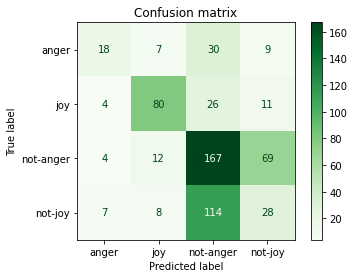

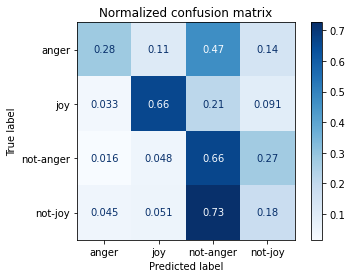

In [ ]:
# classifier=grid_search.best_estimator_
# classifier.fit(feature_matrix_train, train_label)

predictions = gridsearch.predict(test_texts)
acc = accuracy_score(test_labels, predictions)
conf = confusion_matrix(test_labels, predictions)

print(f"Test accuracy: {acc:0.2f}")
# print("Confusion matrix:\n", conf)
print()
# note here we have to feed in the test data not feature matrix since esitimator is a pipeline, not a classifier!
plot_confusion_matrix(gridsearch.best_estimator_, test_texts, test_labels, cmap='Greens', values_format='d')  
plt.title("Confusion matrix")
plt.show()

plot_confusion_matrix(gridsearch.best_estimator_, test_texts, test_labels, cmap='Blues', normalize='true')  
plt.title("Normalized confusion matrix")
plt.show()

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

       anger       0.55      0.28      0.37        64
         joy       0.75      0.66      0.70       121
   not-anger       0.50      0.66      0.57       252
     not-joy       0.24      0.18      0.20       157

    accuracy                           0.49       594
   macro avg       0.51      0.45      0.46       594
weighted avg       0.48      0.49      0.48       594



In [ ]:
# costs = np.logspace(-4, 2, num=6, endpoint = False) # array with values: 0.00001, 0.0001, 0.001, 0.01 0.1, 1
# adjusted, was array with values: 0.00001, 0.0001, 0.001, 0.01 0.1, 1 AND 1 was best
costs = np.logspace(-1, 2, num=6, endpoint = False)
costs

array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ,
       31.6227766 ])

#### NN


To build a NN we need to

1.   turn numpy vectors to tensors
2.   know the shape of input layer (number of features)
3.   know the shape of output layer (number of classes)

TfidfVectorizer gives the 2nd one and LabelEncoder (for example) the 3rd one. (or just len(set(train_labels))

"Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class."(https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)

In [ ]:
# 1) np vectors to TF tensors
import tensorflow as tf
import numpy as np

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

Since vectorizer affects the shape of the NN, we do not optimize it as a part of the pipeline.

In [ ]:
# 2) size of input 
new_token_pattern=r"(?u)\b\w\w+\b|!+|\?+"
vectorizer = TfidfVectorizer(token_pattern=new_token_pattern, max_features=10000)

ft_matrix = vectorizer.fit_transform(train_texts)
ft_matrix.shape # so we need the second dimension for building the nn
input_size = ft_matrix.shape[1]
input_size

9132

In [ ]:
# 3) size_of_output_layer
# use encoded labels when fitting the model and for testing
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder() #Turns class labels into integers
class_numbers_train = label_encoder.fit_transform(train_labels)

# print("class_numbers shape=", class_numbers_train.shape)
print("class labels", label_encoder.classes_) #this will let us translate back from indices to labels

output_size = len(label_encoder.classes_)
print("Shape of output layer:", output_size)

class labels ['anger' 'joy' 'not-anger' 'not-joy']
Shape of output layer: 4


In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout
from keras import optimizers

def build_sequential_nn(input_size=100, output_size=2, hiddenlayer_size=200, drop_out= 0.3, learning_rate=0.001): # let's make 200 default
  model = Sequential()
  model.add(Input(shape = (input_size, )))
  model.add(Dense(hiddenlayer_size, activation = "tanh", ))
  model.add(Dropout(rate=drop_out)) # Dropout regularizer to avoid over fitting
  model.add(Dense(output_size, activation = "softmax"))
  model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=['accuracy'])
  # loss="categorical_crossentropy" for multiclass classification
  return model

model = build_sequential_nn(input_size=input_size, output_size=output_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1826600   
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 1,827,404
Trainable params: 1,827,404
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import FunctionTransformer
from keras.callbacks import EarlyStopping
import time

pipeline = Pipeline([
    ('trans', FunctionTransformer(convert_sparse_matrix_to_sparse_tensor)), # wrapper for custom function
    ('clf', KerasClassifier(build_fn=build_sequential_nn)), # wrapper for Keras model
])

parameters = {
    'clf__hiddenlayer_size': (200, 250), 
    'clf__input_size': ([input_size]), # GS sets ALL the params
    'clf__output_size': ([output_size]),
    'clf__batch_size': (16, 32),
    'clf__drop_out': (0.2, 0.3, 0.4),
    'clf__epochs': (3, 5), # do not use early stopping callback, number of epochs is best treated as a hyper parameter: https://stackoverflow.com/questions/48127550/early-stopping-with-keras-and-sklearn-gridsearchcv-cross-validation
    'clf__learning_rate': (0.001, 0.01)
}

t0=time.time()
print("Running grid search...")
gridsearch = GridSearchCV(pipeline, parameters, verbose=1, n_jobs=1) # n_jobs=-1: use as many cores as possible OR use GPU
gridsearch.fit(ft_matrix, class_numbers_train)
print()

print(f"Best score: {gridsearch.best_score_:0.2}")

print("Best of the observed hyperparameters:")
best_parameters = gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
      print(f"{param_name}: {best_parameters[param_name]}")

t1=time.time()

Running grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Streaming output truncated to the last 5000 lines.
Epoch 8/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0904 - accuracy: 0.9580
Epoch 9/15
117/117 [==============================] - 1s 11ms/step - loss: 0.0914 - accuracy: 0.9516
Epoch 10/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0859 - accuracy: 0.9463
Epoch 11/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0820 - accuracy: 0.9519
Epoch 12/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0696 - accuracy: 0.9622
Epoch 13/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0730 - accuracy: 0.9588
Epoch 14/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0676 - accuracy: 0.9579
Epoch 15/15
30/30 [==============================] - 0s 1ms/step - loss: 1.7463 - accuracy: 0.4635
Epoch 1/15
117/117 [==============================] - 2s 10ms/step - loss: 1.3173 - accuracy: 0.3978
Epoch 2/15
117/117 [=================

In [ ]:
print(f"Time elapsed{t1-t0}")

In [ ]:
means = gridsearch.cv_results_['mean_test_score'] 

GSCV_results = pd.DataFrame(list(zip(means, gridsearch.cv_results_['params'])), 
               columns =['Score', 'Parameters']) 
# sort by the score
GSCV_results.sort_values(by="Score", ascending=False, inplace=True)
print(GSCV_results.head(7))

       Score                                                                                                                                                                  Parameters
26  0.478328  {'clf__batch_size': 32, 'clf__drop_out': 0.2, 'clf__epochs': 3, 'clf__hiddenlayer_size': 250, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
40  0.476172  {'clf__batch_size': 32, 'clf__drop_out': 0.4, 'clf__epochs': 3, 'clf__hiddenlayer_size': 200, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
32  0.473606  {'clf__batch_size': 32, 'clf__drop_out': 0.3, 'clf__epochs': 3, 'clf__hiddenlayer_size': 200, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
34  0.472739  {'clf__batch_size': 32, 'clf__drop_out': 0.3, 'clf__epochs': 3, 'clf__hiddenlayer_size': 250, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
0   0.472321  {'clf__batch_size': 16, 'clf__drop_out': 0.2, 'clf__epochs': 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test accuracy: 0.50



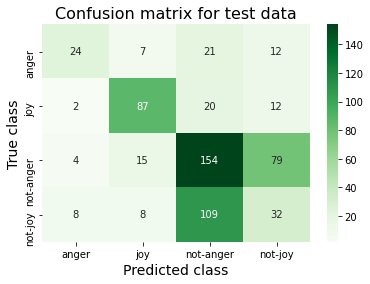

In [ ]:
import seaborn as sns

# prepare test data
ftm_test=vectorizer.transform(test_texts) # model needs to be Sequential for predicting
class_numbers_test = label_encoder.transform(test_labels)

# predict
raw_predictions = gridsearch.predict(ftm_test)
predictions=label_encoder.inverse_transform(raw_predictions)

# results
acc = accuracy_score(test_labels, predictions)
print(f"Test accuracy: {acc:0.2f}")
print()
cf_mat = tf.math.confusion_matrix(
    class_numbers_test, raw_predictions, num_classes=None, weights=None
)

def plot_cf_matrix(mat):
  sns.heatmap(mat, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Greens')
  plt.title("Confusion matrix for test data", fontsize = 16)
  plt.ylabel("True class", fontsize = 14)
  plt.xlabel("Predicted class", fontsize = 14)

plot_cf_matrix(cf_mat)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

       anger       0.63      0.38      0.47        64
         joy       0.74      0.72      0.73       121
   not-anger       0.51      0.61      0.55       252
     not-joy       0.24      0.20      0.22       157

    accuracy                           0.50       594
   macro avg       0.53      0.48      0.49       594
weighted avg       0.50      0.50      0.49       594



In [ ]:
# From NLP deep learning and ADA courses:

#  Additionally accuracy on the permutated test sets are computed for the purpose of 
# ensuring that performance with actual data differs from performance with junk data.

 # accuracy on permutated test set
    # permutated = np.random.permutation(df_test.reg)
    # perm_accuracy, _ = mnb_compute(vocab['test_fm'], permutated, mnb)

#### Sidenote: How to tackle randomness?

What should be done to make sure our results are not random: resuffle the data, run the CV again. Do this x 10 and take the average.

Run with permuted data

For joy and not-anger the model finds a bit less than 70 percent of the relevant samples (recall). For joy also precision (relevance of the selected ones) is rather high, close to 80 percent, so the model detects joy the best. This can be seen also from the f1-score. 

Not-anger, the biggest class in our data, has the second highest f1-score and recall close to 70 percent, but since significant amount of not-joy is assigned under not-anger label, the precision for the class is less than 50 percent. Anger seems to be difficult to detect (recall less than 30 percent) but when the model does so, precision is colse to 60 percent. As already mentioned, not-joy is frequently classified to be not-anger, and that is why all the performance measures for this class are poor.

We reach test accuracy around 50 percent. This slightly outperforms our rather naive baseline of guessing the most common class but does not give us results to celebrate with.

Initially we had one data set for "joy" and "not-joy" and other for "anger" and "not-anger". Test accuracy was around 0.84 while testing with anger and joy data separately.

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

       anger       0.59      0.27      0.37        64
         joy       0.76      0.68      0.72       121
   not-anger       0.49      0.67      0.56       252
     not-joy       0.21      0.14      0.17       157

    accuracy                           0.49       594
   macro avg       0.51      0.44      0.45       594
weighted avg       0.48      0.49      0.47       594



In [ ]:
# set the hyperparameter grid
costs = np.logspace(-4, 2, num=6, endpoint = False) # array with values: 0.00001, 0.0001, 0.001, 0.01 0.1, 1

Reminder:

Precision: TP/TP+FP --> fraction of true positives of all the items predicted positive. i.e. relevance among the selected items

Recall: TP/TP+FN --> fraction of true positives of all the truly positives. i.e relevant items

- Optimize precision: To achieve high precision we can set high threshold for predicting positive. But this would lead to discarding many positives and thus high FN and bad recall

- Optimize recall: To achieve high recall we must minimize FP. This is achieved by setting a low thrwshold for predicting positive. But this again leads to bad precision!

- Goal: Seek for balance. This migt be achieved by setting the metrics used in training.

## Model performance evaluation


Let's take a look at the classified test documents. Can we get an insight what went wrong and why?

In [ ]:
df = pd.DataFrame({'true':test_labels,
                   'prediction':list(predictions),
                   'document':test_texts})
print(df.shape)
df.head()

(594, 3)


,true,prediction,document
0,joy,joy,Se on kuulemma tosi hyvä.
1,not-anger,not-anger,Se ei ole niin yksinkertaista.
2,not-joy,not-anger,Se on vika järjestelmässäsi. Alex Murphy on kuollut.
3,not-anger,not-anger,Sikasi pitää hassua ääntä.
4,not-anger,joy,Helpompi hengittely on varmaan mukavampaa ku kaljottelu.


Most of the missclassifications happened when true label was "not-joy" and prediction was falsely "not-anger".

In [ ]:
df1 = df[(df['true']=='not-joy') & (df['prediction']=='not-anger')]
print(df1.shape)
df1.head(20)

(109, 3)


,true,prediction,document
2,not-joy,not-anger,Se on vika järjestelmässäsi. Alex Murphy on kuollut.
7,not-joy,not-anger,"Kuninkaan käskyä noudatettiin , vaikka siitä tehtiinkin useita valituksia ."
10,not-joy,not-anger,"Mitä tehdä, kun lääkäri ei usko puhetta? https://t.co/eJQCOGBDxf"
17,not-joy,not-anger,Muut äidit joutuvat tyytymään siihen mitä luonto antaa.
22,not-joy,not-anger,Dorcas hyvä Rouva Inglethorp on kuollut. Siksi meidän tulee saada tietää kaikki.
27,not-joy,not-anger,"Se hyväksytään jokaisessa tuomioistuimessa - mutta veisin asian jokaiseen tuomioistuimeen, muistakaa se."
30,not-joy,not-anger,Halusin vain lämmittää häntä.
42,not-joy,not-anger,"Jossitteluja sain minäkin palstalla, mutta kukaan ei osunut oikeaan."
45,not-joy,not-anger,Tuulen puoleisen rinteen ilmavirrat tärisyttävät hiukan.
47,not-joy,not-anger,"Voit olla ravintoasiantuntija, vaikka et ole saanut edes yhtä tuntia opetusta yhtään mistään ravintoon liittyvästä."


The next common miss classification was to predict "not-anger" to "not-joy".

In [ ]:
df2 = df[(df['true']=='not-anger') & (df['prediction']=='not-joy')]
print(df2.shape)
df2.head(20)

(79, 3)


,true,prediction,document
6,not-anger,not-joy,Terveydenhuollossa siirryttävä reaktiivisesta kohti proaktiivista ja prediktiivistä toimintatapaa.
18,not-anger,not-joy,Älä kiinnitä huomiota. Anna hänet minulle.
21,not-anger,not-joy,Sun täytyy ruveta terveeksi.
25,not-anger,not-joy,"Jos tiedätte missä hän on, kertokaa minulle, ennen kuin on liian myöhaistä."
28,not-anger,not-joy,Miksi hän kirjoittaa sellaista?
33,not-anger,not-joy,"Hän on hermostunut, tiedäksä?"
36,not-anger,not-joy,"” Houston , meillä on ongelma . ”"
37,not-anger,not-joy,Usko Jumalaan on ihmisen normaali ja terve elämänasenne.
39,not-anger,not-joy,"Ei Liliuksen palkkiot ehkä ole kovin oikeudenmukaisia, mutta ei siihen erityisesti taida olla hyviä keinoja puuttua."
40,not-anger,not-joy,irl ei oikeastaan ratkaise yhtään mitään.


In both of the above cases the documents seem neutral. They truly are not angry neither happy, so classifying these text truly is a tough problem. 

Since data was labeled in two rounds, first detecting joy and marking "not-joy" those documents that did not express joy, and then on the second roud detecting anger and marking the rest "not-anger", in the similar binary fashion, the classes not-joy and not-anger might have formed sort of "garbage classes", containing no emotion or perhaps some emotion but not the one that was looked for. This might lead to situation where the documents in classes "not-joy" and "not-anger" contain no signal for the classifier or some emotion but not joy or anger.

Then again, what do the missclassified "anger" documents look like?

In [ ]:
miss_c_anger = df[(df['true']=='anger') & (df['prediction']!='anger')]
miss_c_anger=miss_c_anger.sort_values(by=['prediction'])
miss_c_anger.shape
miss_c_anger.head(50)

,true,prediction,document
589,anger,joy,Jumala kirotkoon teidät kaikki!
385,anger,joy,@villekoski @juho_koli Vituttaa FB tyyli ilmoitella kaikesta mistä olen sanoen että aion osallistua.
171,anger,joy,Pyyhi tuo ääliömäinen hymy kasvoiltasi!
473,anger,joy,Siis vaahtosi intona sähköiskuja antavasta pannasta!!??
491,anger,joy,Se oli laiton liike!
305,anger,joy,"Pelkästään tuon takia varmistan, että saat kärsiä, puta!"
502,anger,joy,Tässä asiaankuuluva kommentti ; Turhaa!
490,anger,not-anger,Minä teen siitä lopun.
488,anger,not-anger,Enkö käskenyt sinun pysyä kaukana työpöydästäni?
588,anger,not-anger,Suututtaa .


Note here: lots of exclamation marks: these are stripped off from the training data by the vectorizer!

Now what does true and correctly classified anger look like?

In [ ]:
anger = df[(df['true']=='anger') & (df['prediction']=='anger')]
print(anger.shape)
anger.head(50)

(24, 3)


,true,prediction,document
50,anger,anger,Vihaan näitä hinttarimaisia donitsejasi!
64,anger,anger,Vihaan sitä pihiä paskiaista.
97,anger,anger,Mitä vittua ?
99,anger,anger,En halua kuunnella paskaa! - Varo sanojasi.
103,anger,anger,Sanoin sinulle: vältä hankaluuksia.
168,anger,anger,Älä sano noin edes piloillasi.
194,anger,anger,"Helkkari , kaikki epäonnistuu , jos sinä et nyt auta !"
224,anger,anger,Vihaan tätä koko hommaa.
259,anger,anger,Mitä paskaa sä jauhat ?
281,anger,anger,Mitä vittua sinä höpiset?


This does not need any more explanation, lots of coarse language! The problem with anger classification might lie partly in our input data: class anger is the smallest one of them all.

In [ ]:
joy = df[(df['true']=='joy') & (df['prediction']=='joy')]
joy.shape
joy.head(50)

,true,prediction,document
0,joy,joy,Se on kuulemma tosi hyvä.
13,joy,joy,"Ja rakastin hienoa miestä, isääni."
20,joy,joy,"Voi veljet, kuinka iloinen olen nähdessäni sinut!"
34,joy,joy,"Vierailunne on ollut suuri ilo, herra kenraali."
48,joy,joy,Samppanja oli hyvä idea.
55,joy,joy,"Tulkaa, on täällä mukavaa"
58,joy,joy,"Olo oli tosi itsevarma , tuntui että olin saavuttanut jotain elämässäni , ja vielä jotain hyvää oli tulossa ."
61,joy,joy,"lsä, onpa hauskaa nähdä sinut."
73,joy,joy,Se oli elämäni paras päivä .
80,joy,joy,"Tuo on toistaiseksi tärkein todiste, minkä olemme kuulleet."


In [ ]:
# If and when errors were made, what kind of errors?

In [ ]:
# # note here we have to feed in the test data not feature matrix since esitimator is a pipeline, not a classifier!
# plot_confusion_matrix(gridsearch.best_estimator_, test_text, test_label, cmap='Greens', values_format='d')  
# plt.title("Confusion matrix")
# plt.show()

# plot_confusion_matrix(gridsearch.best_estimator_, test_text, test_label, cmap='Blues', normalize='true')  
# plt.title("Normalized confusion matrix")
# plt.show()

In [ ]:
# print(classification_report(test_label, predictions))

## Final notes